In [60]:
"""
This code makes diagnostic plots for raw and postprocessed WRF-Solar output
Postprocessing using the Kalman Filter is from Rafael Alvarenga's code (rafael.alvarenga@etu.univ-guyane.fr)
"""
import glob
import os
import numpy as np
import pandas as pd


import matplotlib.dates as md
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec

import pytz
import datetime
import math

from tqdm import tqdm

from scipy import stats
from scipy.stats import pearsonr
from scipy.stats import kendalltau
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

from numpy import dot
from numpy.linalg import inv

In [8]:
tz = pytz.timezone("Asia/Manila")
resolution = '10Min'

In [9]:
a = pd.read_csv('with_flags.csv')
a['Time'] = pd.to_datetime(a['Time'])

a['ghi_obs'] = a['SPN1_Total_Solar']
a.columns

Index(['Unnamed: 0', 'Time', 'CMP22_Total_Solar', 'SPN1_Total_Solar',
       'SPN1_Diff_Solar', 'CGR4_IR', 'dhi', 'ghi_a', 'sza', 'cossza', 'dni',
       'MM', 'DD', 'HH', 'mm', 'GHI_in', 'DNI_in', 'DHI_in', 'cossza_b',
       'SPN1_Total_Solar_N', 't2_lim', 'cossza_noon', 'FT_t', 'FT_TOA',
       'FT_TOA_t', 't3_llim', 't3_ulim', 'Diffuse_Ratio', 'SPN1_Diff_Solar_N',
       'sigma', 'ghi_cc_val', 'dhi_cc_val', 't1_lim', 'flag_clear', 'ghi_obs'],
      dtype='object')

In [10]:
path = '/Users/apple/Desktop/Others/Python_Codes/wrf_solar/csv_2023_runs/' # use your path
all_files = glob.glob(os.path.join(path, "*.csv"))

mod_ = []

for f in all_files:
    mod = pd.read_csv(f)
    mod['Time'] = pd.to_datetime(mod['time'])#.dt.tz_localize(tz)
    mod = mod.set_index('Time')
    t0 = mod.index[0] + datetime.timedelta(hours=21)
    tf = t0 + datetime.timedelta(hours=14)
    mod['plot'] = 'N'
    mod.loc[((mod.index >= t0) & (mod.index<= tf)), 'plot'] = 'Y'
    mod=mod[mod['plot']=='Y']
    mod = mod.reset_index()
    mod_.append(mod)
    
mod_ = pd.concat(mod_)


mod_ = mod_[['Time', 'ens', 'ghi', 'swddni', 'coszen', 'swddif', 'lon', 'lat', 'hour', 'station_name',
       'domain']]
mod_ = pd.melt(mod_, id_vars=['Time', 'ens', 'domain', 'station_name'], value_vars=['ghi'] ,value_name='ghi_mod')


In [16]:
#MO

#ensmean
mod_d01 = mod_[(mod_['ens']== 'ensmean') & (mod_['domain']== 'd01') & (mod_['station_name']== 'MO')]
mod_d02 = mod_[(mod_['ens']== 'ensmean') & (mod_['domain']== 'd02') & (mod_['station_name']== 'MO')]
mod_d01

,Time,ens,domain,station_name,variable,ghi_mod
120,2020-01-16 05:00:00+08:00,ensmean,d01,MO,ghi,0.00000
121,2020-01-16 06:00:00+08:00,ensmean,d01,MO,ghi,0.00000
122,2020-01-16 07:00:00+08:00,ensmean,d01,MO,ghi,102.70935
123,2020-01-16 08:00:00+08:00,ensmean,d01,MO,ghi,339.48013
124,2020-01-16 09:00:00+08:00,ensmean,d01,MO,ghi,556.75080
...,...,...,...,...,...,...
9880,2020-02-11 15:00:00+08:00,ensmean,d01,MO,ghi,648.91100
9881,2020-02-11 16:00:00+08:00,ensmean,d01,MO,ghi,427.68546
9882,2020-02-11 17:00:00+08:00,ensmean,d01,MO,ghi,180.44148
9883,2020-02-11 18:00:00+08:00,ensmean,d01,MO,ghi,0.00000


In [17]:
mod_d01  = mod_d01.set_index('Time')
mod_d01  = mod_d01.resample(resolution).interpolate(method='linear')
mod_d01  = mod_d01.reset_index(drop = False)
mod_d01['station_name']  = 'MO'
mod_d01['domain']  = 'd01'
mod_d01['ens']  = 'ensmean'

mod_d01  = mod_d01.set_index('Time')
mod_d01  = mod_d01.resample(resolution).interpolate(method='linear')
mod_d02  = mod_d02.reset_index(drop = False)
mod_d02['station_name']  = 'MO'
mod_d02['domain']  = 'd02'
mod_d02['ens']  = 'ensmean'

d01_mo_mean = a.merge(mod_d01, how='inner', on='Time')
d01_mo_mean['Time'] = pd.to_datetime(d01_mo_mean['Time']).dt.tz_convert(tz)


d01_mo_mean = d01_mo_mean.set_index('Time')
d01_mo_mean['YY'] = pd.DatetimeIndex(d01_mo_mean.index).year
d01_mo_mean['MM'] = pd.DatetimeIndex(d01_mo_mean.index).month
d01_mo_mean['DD'] = pd.DatetimeIndex(d01_mo_mean.index).day
d01_mo_mean['HH'] = pd.DatetimeIndex(d01_mo_mean.index).hour
d01_mo_mean['mm'] = pd.DatetimeIndex(d01_mo_mean.index).minute
d01_mo_mean = d01_mo_mean.reset_index()


d02_mo_mean = a.merge(mod_d02, how='inner', on='Time')
d02_mo_mean['Time'] = pd.to_datetime(d02_mo_mean['Time']).dt.tz_convert(tz)


d02_mo_mean = d02_mo_mean.set_index('Time')
d02_mo_mean['YY'] = pd.DatetimeIndex(d02_mo_mean.index).year
d02_mo_mean['MM'] = pd.DatetimeIndex(d02_mo_mean.index).month
d02_mo_mean['DD'] = pd.DatetimeIndex(d02_mo_mean.index).day
d02_mo_mean['HH'] = pd.DatetimeIndex(d02_mo_mean.index).hour
d02_mo_mean['mm'] = pd.DatetimeIndex(d02_mo_mean.index).minute
d02_mo_mean = d02_mo_mean.reset_index()


In [34]:
df = d01_mo_mean
if 'Error_rel' not in df.columns:
    # Function to calculate relative errors
    def calculate_relative_errors(pred, obs):
        if obs == 0:
            return np.nan
        else:
            return (pred - obs)/obs
    # recalculate relative error after removing some observations
    df['Error_rel'] = df.apply(lambda row : calculate_relative_errors(row['ghi_mod'], row['ghi_obs']), axis = 1)


In [35]:
#line 221
df['Kc_GHI_pred'] = df['ghi_mod']/df['GHI_in']
df['Kc_GHI_pred'] = df['Kc_GHI_pred'].replace(np.inf,np.nan)

df['Kc_GHI_obs'] = df['ghi_obs']/df['GHI_in']

#line 223
# create clear-sky index column for observed errors 
df['Kc_obs_bias'] = df['Kc_GHI_pred'] - df['Kc_GHI_obs']




In [36]:

df['LT'] = (df['HH']*60)+df['mm']
df

,Time,Unnamed: 0,CMP22_Total_Solar,SPN1_Total_Solar,SPN1_Diff_Solar,CGR4_IR,dhi,ghi_a,sza,cossza,...,domain,station_name,variable,ghi_mod,YY,Error_rel,Kc_GHI_pred,Kc_GHI_obs,Kc_obs_bias,LT
0,2020-01-16 06:30:00+08:00,1004,0.016802,15.279198,11.717499,1202.902004,11.717499,15.279198,89.163074,0.014607,...,d01,MO,NaN,51.354675,2020,2.361085,131.332849,39.074545,92.258304,390
1,2020-01-16 06:40:00+08:00,1005,0.058873,49.183913,20.992307,1204.117039,20.992307,49.183913,87.104864,0.050508,...,d01,MO,NaN,68.472900,2020,0.392181,9.268698,6.657683,2.611015,400
2,2020-01-16 06:50:00+08:00,1006,0.065792,55.243904,23.202902,1204.582233,23.202902,55.243904,84.956502,0.087912,...,d01,MO,NaN,85.591125,2020,0.549332,3.216819,2.076262,1.140556,410
3,2020-01-16 07:00:00+08:00,1007,0.117346,100.511853,29.500008,1207.653611,29.500008,100.511853,82.782722,0.125632,...,d01,MO,ghi,102.709350,2020,0.021863,1.860553,1.820746,0.039807,420
4,2020-01-16 07:10:00+08:00,1008,0.155374,138.397671,34.556633,1211.386657,34.556633,138.397671,80.605436,0.163232,...,d01,MO,NaN,142.171147,2020,0.027265,1.590530,1.548314,0.042215,430
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1809,2020-02-11 17:10:00+08:00,4814,0.059297,69.931744,44.257051,1235.070679,44.257051,69.931744,79.517432,0.181936,...,d01,MO,NaN,150.367900,2020,1.150209,1.412651,0.656983,0.755668,1030
1810,2020-02-11 17:20:00+08:00,4815,0.028580,30.365263,28.386377,1229.536193,28.386377,30.365263,81.803756,0.142564,...,d01,MO,NaN,120.294320,2020,2.961577,1.740478,0.439340,1.301138,1040
1811,2020-02-11 17:30:00+08:00,4816,0.016745,20.279092,18.880316,1227.709919,18.880316,20.279092,84.085972,0.103036,...,d01,MO,NaN,90.220740,2020,3.448954,2.461774,0.553338,1.908436,1050
1812,2020-02-11 17:40:00+08:00,4817,0.011210,14.618756,13.509744,1226.630578,13.509744,14.618756,86.347644,0.063702,...,d01,MO,NaN,60.147160,2020,3.114383,4.750468,1.154601,3.595868,1060


In [37]:
# ----------------------------
#    Remove early morning and late afternoon
# ----------------------------
df = df.loc[(df['Time'].dt.hour >= 8) & (df['Time'].dt.hour <= 17)].copy()

df = df.reset_index(drop = False)
    
#for predictors_vector in [['Kc_GHI_pred','Q2_rel']]:# [results_best_MBE.loc[results_best_MBE.index[-1], 'Predictors'].split('-')[1:], results_best_MAE.loc[results_best_MAE.index[-1], 'Predictors'].split('-')[1:]]:
#df_temp = df.copy()
df['Kc_GHI_pred_improved'] = np.nan 
df['predicted_coefs'] = np.nan 
df = df[['Time', 'LT','CMP22_Total_Solar', 'SPN1_Total_Solar',
       'SPN1_Diff_Solar', 'CGR4_IR', 'YY', 'MM', 'HH', 'mm', 'dhi',
       'ghi_obs', 'sza', 'cossza', 'dni',  'GHI_in', 'DNI_in', 'DHI_in', 'cossza_b',
       'SPN1_Total_Solar_N', 't2_lim', 'cossza_noon', 'FT_t', 'FT_TOA',
       'FT_TOA_t', 't3_llim', 't3_ulim', 'Diffuse_Ratio', 'SPN1_Diff_Solar_N',
       'sigma', 'ghi_cc_val', 'dhi_cc_val', 't1_lim', 'flag_clear',\
         'ens', 'domain','station_name', 'ghi_mod', 'Error_rel', 'Kc_GHI_pred', 'Kc_GHI_obs', 'Kc_obs_bias',
       'Kc_GHI_pred_improved']]
#df.to_csv('before.csv')

In [22]:
# define number of historical timesteps necessary for a next-timestep post-processing

#[3,7,14,21,28,35,42,49,56,63,70]
for nb_historical_days in [3,7,14,21,28]:
    df_temp = df
    nb_LTs = len(np.unique(df_temp.LT))

    timestep_enough_historical = (nb_historical_days*2)*nb_LTs 
    print(timestep_enough_historical)
    recursive_calculation_covariance_matrices = True
    predictors_vector = ['Kc_GHI_pred', 'cossza']
    #print(predictors_vector)

    idx_t = 0
    for t in tqdm(range(len(df_temp))):

        hour = df_temp.loc[t,'Time'].hour
        minutes = df_temp.loc[t,'Time'].minute
        #print(f'Time: {lt_hours}:{lt_minutes:02d} (+{lt})')


        if t >= timestep_enough_historical:
            # slice df
            df_timestep = df_temp.loc[t-(nb_historical_days*nb_LTs)-(nb_historical_days*nb_LTs*recursive_calculation_covariance_matrices):t,:].copy()
        else:
            df_timestep = df_temp.loc[t:t+(nb_historical_days*nb_LTs)+(nb_historical_days*nb_LTs*recursive_calculation_covariance_matrices),:].copy()
            df_timestep = df_timestep[::-1].reset_index(drop=True)
        df_timestep = df_timestep.loc[(df_timestep['Time'].dt.hour == hour) & (df_timestep['Time'].dt.minute == minutes)]
        df_timestep = df_timestep.loc[~np.isnan(df_timestep['Kc_GHI_pred'])]
        df_timestep = df_timestep.loc[~np.isnan(df_timestep['Kc_obs_bias'])]
        #print(df_timestep)
        if (len(df_timestep) == 0) & (len(df_timestep) <= nb_historical_days + (nb_historical_days*recursive_calculation_covariance_matrices) or (t not in df_timestep.index)):
            df_temp.loc[t,'Kc_GHI_pred_improved'] = np.nan  
            continue

        df_timestep = df_timestep.iloc[-(nb_historical_days+1)-(nb_historical_days*recursive_calculation_covariance_matrices):,:]
        df_timestep = df_timestep.reset_index(drop = True)

        p_v=2
        # define prediction-bias variance matrix
        W = np.eye(p_v)/1000

        # define measurement-bias variance matrix
        V = 0.01

        # define initial error covariance matrix
        Po = np.eye(p_v)*5

        # define initial predicted bias
        xo = np.zeros(p_v).reshape(p_v,1)

        measurement_GHI = []
        old_predicted_GHI = []
        improved_GHI = []
        ground_truths = []
        predicted_coefs = []

        for idx_i, i in enumerate(df_timestep.index):
            if recursive_calculation_covariance_matrices == True:
                # --------------------------------------------
                #  Calculate matrices of covariance of errors
                # --------------------------------------------
                if idx_i > nb_historical_days:
                    mean_w = sum(predicted_coefs[-(1+day)] - predicted_coefs[-(2+day)] for day in range(nb_historical_days))/nb_historical_days
                    mean_v = sum(measurement_GHI[-(1+day)] - improved_GHI[-(1+day)] for day in range(nb_historical_days))/nb_historical_days

                    # old method
                    W = np.diag(list((1/(nb_historical_days-1))*sum(((predicted_coefs[-(1+day)] - predicted_coefs[-(2+day)]) - mean_w)**2 for day in range(nb_historical_days)).reshape(len(predictors_vector),)))
                    V = (1/(nb_historical_days-1))*sum(((measurement_GHI[-(1+day)] - improved_GHI[-(1+day)]) - mean_v)**2 for day in range(nb_historical_days))

                    # # improved method (from Lynch, 2014 - Simplified method to derive the Kalman Filter covariance matrices to predict wind speeds from a NWP model)
                    # W = (1/(nb_historical_days-1))*sum(dot(((predicted_coefs[-(1+day)] - predicted_coefs[-(2+day)]) - mean_w),((predicted_coefs[-(1+day)] - predicted_coefs[-(2+day)]) - mean_w).T) for day in range(nb_historical_days))
                    # V = (1/(nb_historical_days-1))*sum(dot(((measurement_GHI[-(1+day)] - improved_GHI[-(1+day)]) - mean_v),((measurement_GHI[-(1+day)] - improved_GHI[-(1+day)]) - mean_v).T) for day in range(nb_historical_days))

            # ----------------------------
            #           Predict
            # ----------------------------

            if idx_i == 0:
                # predicted mean bias
                x_pred = np.zeros_like(xo)
                x_pred = xo

                # predicted bias covariance matrix
                P = Po + W

            else:
                # predicted mean bias
                x_pred = x_pred
                #x_pred[1:,0] = 0 # only bias is being tracked, our prediction model doesn't account for the other predictors

                # predicted bias covariance matrix
                P = P + W

            # ----------------------------
            #           Update
            # ----------------------------

            # compute transition matrix based on the current predictors for this timestep
            H = [df_timestep.loc[i,predictor] for predictor in predictors_vector[1:]]
            H = np.asarray([1] + H).reshape(1, len(predictors_vector))

            ground_truths.append(df_timestep.loc[i,'Kc_GHI_obs'])
            predicted_coefs.append(x_pred)
            improved_GHI.append(dot(H,x_pred))
            df_timestep.loc[i,'Kc_GHI_pred_improved'] = improved_GHI[-1][0,0]

            # compute residual mean bias and residual bias covariance

            new_measurement = df_timestep.loc[i,'Kc_GHI_obs']
            residual_mean = new_measurement - dot(H,x_pred)
            residual_covariance = dot(H, P).dot(H.T) + V

            # compute Kalman gain based on the transition matrix and residual covariance
            K = dot(P, H.T).dot(inv(residual_covariance)) # from documentation https://filterpy.readthedocs.io/en/latest/index.html#use
            K = np.nan_to_num(K, nan = 0)

            # update mean bias after incorporating measurements
            x_pred = x_pred + dot(K,residual_mean)

            # update bias covariance matrix after incorporating measurements
            #P = dot(K,H).dot(P) # from https://www.youtube.com/watch?v=W0gai93yhsM
            P = np.dot(np.eye(len(predictors_vector)) - dot(K,H),P)

            measurement_GHI.append(new_measurement)
            old_predicted_GHI.append(df_timestep.loc[i,'Kc_GHI_pred'])
        # assign final prediction
        df_temp.loc[t,'Kc_GHI_pred_improved'] = improved_GHI[-1][0,0]
        measurement_GHI = np.asarray(measurement_GHI)
        improved_GHI = np.asarray(improved_GHI)
        old_predicted_GHI = np.asarray(old_predicted_GHI)
        ground_truths = np.asarray(ground_truths)
        image_folder='img/'
        if idx_t % 1000 == 0:
            # --------------------------------------
            #   Plot training for current timestep
            # --------------------------------------
            # define figure
            plt.figure(figsize=(18, 15))      
            # define points for x-axis
            x = np.arange(len(measurement_GHI))
            # plot curves    
            plt.plot(x, ground_truths, color = 'grey', alpha = 0.8, label = 'Observed GHI')
            plt.plot(x, old_predicted_GHI, color = 'tomato', alpha = 0.8, label = 'Original GHI prediction')
            plt.plot(x, improved_GHI[:,0,0], color = 'cornflowerblue', alpha = 0.8, label = 'Improved GHI prediction')
            #plt.plot(x, filtered_bias[:,0,0], color = 'blue', alpha = 0.8, label = 'Filtered bias')
            plt.ylim(-2,2)
            plt.title(f"KF training for {df_temp.loc[t,'Time'].day:02d}/{df_temp.loc[t,'Time'].month:02d}/{df_temp.loc[t,'Time'].year} {df_temp.loc[t,'Time'].hour:02d}:{df_temp.loc[t,'Time'].minute:02d}", fontsize=18)
            plt.ylabel('Clear-sky index', fontsize = 16)
            plt.xlabel('Historical timesteps', fontsize = 16)
            plt.legend()

            # save figure
            plt.savefig(image_folder + f"{df_temp.loc[t,'Time'].year}_{df_temp.loc[t,'Time'].month:02d}_{df_temp.loc[t,'Time'].day:02d}-{df_temp.loc[t,'Time'].hour:02d}_{df_temp.loc[t,'Time'].minute:02d}.png")
            #plt.show()
            #plt.close()
            plt.cla()
            plt.clf()

        idx_t = idx_t + 1  

    # calculate overall error metrics for this group of predictors
    df_temp['GHI_pred_improved'] = df_temp['Kc_GHI_pred_improved'] * df_temp['GHI_in']

    df_temp = df_temp.loc[~np.isnan(df_temp['GHI_pred_improved'])]
    df_temp = df_temp.loc[~np.isnan(df_temp['ghi_obs'])]

    mae = mean_absolute_error(df_temp['ghi_obs'], df_temp['GHI_pred_improved'])
    mse = mean_squared_error(df_temp['ghi_obs'], df_temp['GHI_pred_improved'])
    mbe = np.mean(df_temp['GHI_pred_improved'] - df_temp['ghi_obs'])
    rms = mean_squared_error(df_temp['ghi_obs'], df_temp['GHI_pred_improved'], squared=False)
    print('\n\n**************************')
    print(f'{nb_historical_days}')
    print(f'- RMS: {rms}')
    print(f'- MAE: {mae}')
    print(f'- MSE: {mse}')
    print(f'- MBE: {mbe}')



360


100%|███████████████████████████████████████| 1571/1571 [00:33<00:00, 47.30it/s]




**************************
3
- RMS: 225.03526739794722
- MAE: 165.24043068591502
- MSE: 50640.87157286561
- MBE: 0.15760320847140477
840


100%|███████████████████████████████████████| 1571/1571 [00:51<00:00, 30.61it/s]




**************************
7
- RMS: 227.72397533155655
- MAE: 166.95776496826707
- MSE: 51858.20894080737
- MBE: 1.1679254040234697
1680


100%|███████████████████████████████████████| 1571/1571 [00:47<00:00, 33.11it/s]




**************************
14
- RMS: 258.5838297842005
- MAE: 183.91415056613903
- MSE: 66865.59702586435
- MBE: -17.153765052687362
2520


100%|███████████████████████████████████████| 1571/1571 [00:46<00:00, 33.85it/s]




**************************
21
- RMS: 255.0043663189985
- MAE: 183.37507832775825
- MSE: 65027.226841753974
- MBE: -12.858809393320213
3360


100%|███████████████████████████████████████| 1571/1571 [00:44<00:00, 35.00it/s]



**************************
28
- RMS: 255.0657861045991
- MAE: 184.07441711515165
- MSE: 65058.55524115711
- MBE: -8.39628510517842


<Figure size 1296x1080 with 0 Axes>

<Figure size 1296x1080 with 0 Axes>

<Figure size 1296x1080 with 0 Axes>

<Figure size 1296x1080 with 0 Axes>

<Figure size 1296x1080 with 0 Axes>

<Figure size 1296x1080 with 0 Axes>

<Figure size 1296x1080 with 0 Axes>

<Figure size 1296x1080 with 0 Axes>

<Figure size 1296x1080 with 0 Axes>

<Figure size 1296x1080 with 0 Axes>

In [38]:
# define number of historical timesteps necessary for a next-timestep post-processing
df_temp = df
#[3,7,14,21,28,35,42,49,56,63,70]
nb_historical_days = 3
nb_LTs = len(np.unique(df_temp.LT))

timestep_enough_historical = (nb_historical_days*2)*nb_LTs 
print(timestep_enough_historical)
recursive_calculation_covariance_matrices = True
predictors_vector = ['Kc_GHI_pred', 'cossza']
print(predictors_vector)

idx_t = 0
for t in tqdm(range(len(df_temp))):
    
    hour = df_temp.loc[t,'Time'].hour
    minutes = df_temp.loc[t,'Time'].minute
    #print(f'Time: {lt_hours}:{lt_minutes:02d} (+{lt})')
    
    
    if t >= timestep_enough_historical:
        # slice df
        df_timestep = df_temp.loc[t-(nb_historical_days*nb_LTs)-(nb_historical_days*nb_LTs*recursive_calculation_covariance_matrices):t,:].copy()
    else:
        df_timestep = df_temp.loc[t:t+(nb_historical_days*nb_LTs)+(nb_historical_days*nb_LTs*recursive_calculation_covariance_matrices),:].copy()
        df_timestep = df_timestep[::-1].reset_index(drop=True)
    df_timestep = df_timestep.loc[(df_timestep['Time'].dt.hour == hour) & (df_timestep['Time'].dt.minute == minutes)]
    df_timestep = df_timestep.loc[~np.isnan(df_timestep['Kc_GHI_pred'])]
    df_timestep = df_timestep.loc[~np.isnan(df_timestep['Kc_obs_bias'])]
    #print(df_timestep)
    if (len(df_timestep) == 0) & (len(df_timestep) <= nb_historical_days + (nb_historical_days*recursive_calculation_covariance_matrices) or (t not in df_timestep.index)):
        df_temp.loc[t,'Kc_GHI_pred_improved'] = np.nan  
        continue

    df_timestep = df_timestep.iloc[-(nb_historical_days+1)-(nb_historical_days*recursive_calculation_covariance_matrices):,:]
    df_timestep = df_timestep.reset_index(drop = True)
    
    p_v=2
    # define prediction-bias variance matrix
    W = np.eye(p_v)/1000

    # define measurement-bias variance matrix
    V = 0.01

    # define initial error covariance matrix
    Po = np.eye(p_v)*5

    # define initial predicted bias
    xo = np.zeros(p_v).reshape(p_v,1)

    measurement_GHI = []
    old_predicted_GHI = []
    improved_GHI = []
    ground_truths = []
    predicted_coefs = []
    
    for idx_i, i in enumerate(df_timestep.index):
        if recursive_calculation_covariance_matrices == True:
            # --------------------------------------------
            #  Calculate matrices of covariance of errors
            # --------------------------------------------
            if idx_i > nb_historical_days:
                mean_w = sum(predicted_coefs[-(1+day)] - predicted_coefs[-(2+day)] for day in range(nb_historical_days))/nb_historical_days
                mean_v = sum(measurement_GHI[-(1+day)] - improved_GHI[-(1+day)] for day in range(nb_historical_days))/nb_historical_days

                # old method
                W = np.diag(list((1/(nb_historical_days-1))*sum(((predicted_coefs[-(1+day)] - predicted_coefs[-(2+day)]) - mean_w)**2 for day in range(nb_historical_days)).reshape(len(predictors_vector),)))
                V = (1/(nb_historical_days-1))*sum(((measurement_GHI[-(1+day)] - improved_GHI[-(1+day)]) - mean_v)**2 for day in range(nb_historical_days))
                
                # # improved method (from Lynch, 2014 - Simplified method to derive the Kalman Filter covariance matrices to predict wind speeds from a NWP model)
                # W = (1/(nb_historical_days-1))*sum(dot(((predicted_coefs[-(1+day)] - predicted_coefs[-(2+day)]) - mean_w),((predicted_coefs[-(1+day)] - predicted_coefs[-(2+day)]) - mean_w).T) for day in range(nb_historical_days))
                # V = (1/(nb_historical_days-1))*sum(dot(((measurement_GHI[-(1+day)] - improved_GHI[-(1+day)]) - mean_v),((measurement_GHI[-(1+day)] - improved_GHI[-(1+day)]) - mean_v).T) for day in range(nb_historical_days))
        
        # ----------------------------
        #           Predict
        # ----------------------------
    
        if idx_i == 0:
            # predicted mean bias
            x_pred = np.zeros_like(xo)
            x_pred = xo
            
            # predicted bias covariance matrix
            P = Po + W
            
        else:
            # predicted mean bias
            x_pred = x_pred
            #x_pred[1:,0] = 0 # only bias is being tracked, our prediction model doesn't account for the other predictors
            
            # predicted bias covariance matrix
            P = P + W
            
        # ----------------------------
        #           Update
        # ----------------------------
        
        # compute transition matrix based on the current predictors for this timestep
        H = [df_timestep.loc[i,predictor] for predictor in predictors_vector[1:]]
        H = np.asarray([1] + H).reshape(1, len(predictors_vector))
        
        ground_truths.append(df_timestep.loc[i,'Kc_GHI_obs'])
        predicted_coefs.append(x_pred)
        improved_GHI.append(dot(H,x_pred))
        df_timestep.loc[i,'Kc_GHI_pred_improved'] = improved_GHI[-1][0,0]
        
        # compute residual mean bias and residual bias covariance
        
        new_measurement = df_timestep.loc[i,'Kc_GHI_obs']
        residual_mean = new_measurement - dot(H,x_pred)
        residual_covariance = dot(H, P).dot(H.T) + V
        
        # compute Kalman gain based on the transition matrix and residual covariance
        K = dot(P, H.T).dot(inv(residual_covariance)) # from documentation https://filterpy.readthedocs.io/en/latest/index.html#use
        K = np.nan_to_num(K, nan = 0)
        
        # update mean bias after incorporating measurements
        x_pred = x_pred + dot(K,residual_mean)
       
        # update bias covariance matrix after incorporating measurements
        #P = dot(K,H).dot(P) # from https://www.youtube.com/watch?v=W0gai93yhsM
        P = np.dot(np.eye(len(predictors_vector)) - dot(K,H),P)
        
        measurement_GHI.append(new_measurement)
        old_predicted_GHI.append(df_timestep.loc[i,'Kc_GHI_pred'])
    # assign final prediction
    df_temp.loc[t,'Kc_GHI_pred_improved'] = improved_GHI[-1][0,0]
    measurement_GHI = np.asarray(measurement_GHI)
    improved_GHI = np.asarray(improved_GHI)
    old_predicted_GHI = np.asarray(old_predicted_GHI)
    ground_truths = np.asarray(ground_truths)
    image_folder='img/'
    if idx_t % 1000 == 0:
        # --------------------------------------
        #   Plot training for current timestep
        # --------------------------------------
        # define figure
        plt.figure(figsize=(18, 15))      
        # define points for x-axis
        x = np.arange(len(measurement_GHI))
        # plot curves    
        plt.plot(x, ground_truths, color = 'grey', alpha = 0.8, label = 'Observed GHI')
        plt.plot(x, old_predicted_GHI, color = 'tomato', alpha = 0.8, label = 'Original GHI prediction')
        plt.plot(x, improved_GHI[:,0,0], color = 'cornflowerblue', alpha = 0.8, label = 'Improved GHI prediction')
        #plt.plot(x, filtered_bias[:,0,0], color = 'blue', alpha = 0.8, label = 'Filtered bias')
        plt.ylim(-2,2)
        plt.title(f"KF training for {df_temp.loc[t,'Time'].day:02d}/{df_temp.loc[t,'Time'].month:02d}/{df_temp.loc[t,'Time'].year} {df_temp.loc[t,'Time'].hour:02d}:{df_temp.loc[t,'Time'].minute:02d}", fontsize=18)
        plt.ylabel('Clear-sky index', fontsize = 16)
        plt.xlabel('Historical timesteps', fontsize = 16)
        plt.legend()
        
        # save figure
        plt.savefig(image_folder + f"{df_temp.loc[t,'Time'].year}_{df_temp.loc[t,'Time'].month:02d}_{df_temp.loc[t,'Time'].day:02d}-{df_temp.loc[t,'Time'].hour:02d}_{df_temp.loc[t,'Time'].minute:02d}.png")
        #plt.show()
        #plt.close()
        plt.cla()
        plt.clf()
        
    idx_t = idx_t + 1  
    
# calculate overall error metrics for this group of predictors
df_temp['GHI_pred_improved'] = df_temp['Kc_GHI_pred_improved'] * df_temp['GHI_in']

df_temp = df_temp.loc[~np.isnan(df_temp['GHI_pred_improved'])]
df_temp = df_temp.loc[~np.isnan(df_temp['ghi_obs'])]

mae = mean_absolute_error(df_temp['ghi_obs'], df_temp['GHI_pred_improved'])
mse = mean_squared_error(df_temp['ghi_obs'], df_temp['GHI_pred_improved'])
mbe = np.mean(df_temp['GHI_pred_improved'] - df_temp['ghi_obs'])
rms = mean_squared_error(df_temp['ghi_obs'], df_temp['GHI_pred_improved'], squared=False)
print('\n\n**************************')
print(f'Length of df_temp: {len(df_temp)}')
print(f'- MAE: {mae}')
print(f'- RMS: {rms}')
print(f'- MSE: {mse}')
print(f'- MBE: {mbe}')



360
['Kc_GHI_pred', 'cossza']


100%|███████████████████████████████████████| 1571/1571 [00:29<00:00, 52.91it/s]




**************************
Length of df_temp: 1571
- MAE: 165.24043068591502
- RMS: 225.03526739794722
- MSE: 50640.87157286561
- MBE: 0.15760320847140477


<Figure size 1296x1080 with 0 Axes>

<Figure size 1296x1080 with 0 Axes>

In [24]:
def fitting(da):

    x_new = np.linspace(0.01, 1360, 1000)
    x_a=np.array(da['ghi_obs'])
    y_a=np.array(da['ghi_mod'])
    xaa = x_a[~np.isnan(x_a)]
    print('Length ob:' + str(len(xaa)))
    yaa = y_a[~np.isnan(y_a)]
    print('Length obs:' + str(len(yaa)))
    #print(xaa,yaa)
    slope_a, intercept_a, r_value_a, p_value_a, std_err_a = stats.linregress(x_a,y_a)
    pearson_corr, pearson_pval = pearsonr(xaa,yaa)
    coef, p = kendalltau(xaa,yaa)
    print('Kendall correlation coefficient: %.3f' % coef)
    rms = mean_squared_error(xaa, yaa, squared=False)
    mae = mean_absolute_error(xaa, yaa)
    alpha = 0.01
    if p > alpha:
        print('Samples are uncorrelated (fail to reject H0) p=%.3f' % p)
    else:
        print('Samples are correlated (reject H0) p=%.3f' % p)

    print('Pearsons correlation: %.3f' % pearson_corr)
    print('Pearsons p_value: %.3f' % pearson_pval)
    print('RMS: %.3f' % rms)
    print('MAE: %.3f' % mae)
    print('###########################################')
    return (pearson_corr, pearson_pval, slope_a, intercept_a, r_value_a, p_value_a, std_err_a, rms)

def fitting_pred(da):

    x_new = np.linspace(0.01, 1360, 1000)
    x_a=np.array(da['ghi_obs'])
    y_a=np.array(da['GHI_pred_improved'])
    xaa = x_a[~np.isnan(x_a)]
    print('Length pred:' + str(len(xaa)))
    yaa = y_a[~np.isnan(y_a)]
    print('Length pred:' + str(len(yaa)))
    slope_a, intercept_a, r_value_a, p_value_a, std_err_a = stats.linregress(x_a,y_a)
    pearson_corr, pearson_pval = pearsonr(xaa,yaa)
    coef, p = kendalltau(xaa,yaa)
    print('Kendall correlation coefficient: %.3f' % coef)
    rms = mean_squared_error(xaa, yaa, squared=False)
    mae = mean_absolute_error(xaa, yaa)
    
    alpha = 0.01
    if p > alpha:
        print('Samples are uncorrelated (fail to reject H0) p=%.3f' % p)
    else:
        print('Samples are correlated (reject H0) p=%.3f' % p)

    print('Pearsons correlation: %.3f' % pearson_corr)
    print('RMS: %.3f' % rms)
    print('MAE: %.3f' % mae)
    print('###########################################')
    
    return (pearson_corr, pearson_pval, slope_a, intercept_a, r_value_a, p_value_a, std_err_a, rms)


Length ob:1394
Length obs:1394
Kendall correlation coefficient: 0.537
Samples are correlated (reject H0) p=0.000
Pearsons correlation: 0.714
Pearsons p_value: 0.000
RMS: 209.724
MAE: 152.819
###########################################
Length pred:1394
Length pred:1394
Kendall correlation coefficient: 0.394
Samples are correlated (reject H0) p=0.000
Pearsons correlation: 0.527
RMS: 230.901
MAE: 169.818
###########################################


/var/folders/m6/4qg_57053p93nhjn29vdbv940000gp/T/ipykernel_6664/3194616929.py:33: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(f"{images_dir}/kf_Manila_ts_" + str(res) +"km.png", dpi=500, frameon=False, facecolor='white', bbox_inches="tight")


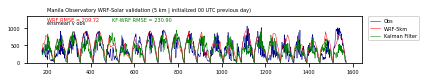

In [25]:
def ts(res, da_mean):
    fig = plt.figure()
    gs = fig.add_gridspec(4, 3)

    ax00 = fig.add_subplot(gs[0, 0:3])

    da_mean = da_mean.iloc[(59*nb_historical_days):,:]
    ax00.plot(da_mean.index,da_mean['ghi_obs'],c='DarkBlue',linewidth=0.5)

    ax00.plot(da_mean.index,da_mean['ghi_mod'],c='red',linewidth=0.5)
    ax00.plot(da_mean.index,da_mean['GHI_pred_improved'],c='green',linewidth=0.5)
 
    ax00.tick_params(axis='both', which='major', labelsize=5)

    ax00.set_ylim(0,1360)



    ax00.text(200, 1500, 'Manila Observatory WRF-Solar validation (' + str(res)+' km | initialized 00 UTC previous day)',  fontsize=5)
    ax00.text(200, 1100, 'ensmean v obs',  fontsize=5)

    
    ax00.text( 200, 1200,'WRF RMSE = %0.2f'%fitting(da_mean)[7], fontsize=5, color='red')
    ax00.text( 500, 1200,'KF-WRF RMSE = %0.2f'%fitting_pred(da_mean)[7], fontsize=5, color='green')
  
  

    #ax00.legend(['WRF-5km','WRF-1.67km','Obs'], bbox_to_anchor=(1.02, 0.98), prop={'size': 5},loc=2, borderaxespad=0.)
    ax00.legend(['Obs','WRF-' + str(res) + 'km', 'Kalman Filter'], bbox_to_anchor=(1.02, 0.98), prop={'size': 5},loc=2, borderaxespad=0.)


    images_dir = 'img'
    plt.savefig(f"{images_dir}/kf_Manila_ts_" + str(res) +"km.png", dpi=500, frameon=False, facecolor='white', bbox_inches="tight")
ts(5, df_temp)


Length ob:1394
Length obs:1394
Kendall correlation coefficient: 0.537
Samples are correlated (reject H0) p=0.000
Pearsons correlation: 0.714
Pearsons p_value: 0.000
RMS: 209.724
MAE: 152.819
###########################################
Length ob:1394
Length obs:1394
Kendall correlation coefficient: 0.537
Samples are correlated (reject H0) p=0.000
Pearsons correlation: 0.714
Pearsons p_value: 0.000
RMS: 209.724
MAE: 152.819
###########################################
Length pred:1394
Length pred:1394
Kendall correlation coefficient: 0.394
Samples are correlated (reject H0) p=0.000
Pearsons correlation: 0.527
RMS: 230.901
MAE: 169.818
###########################################
Length pred:1394
Length pred:1394
Kendall correlation coefficient: 0.394
Samples are correlated (reject H0) p=0.000
Pearsons correlation: 0.527
RMS: 230.901
MAE: 169.818
###########################################


/var/folders/m6/4qg_57053p93nhjn29vdbv940000gp/T/ipykernel_6664/3729371428.py:31: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(f"{images_dir}/kf_Manila_scatplot_" + str((res)) + "km.png", dpi=500, frameon=False, facecolor='white', bbox_inches="tight")


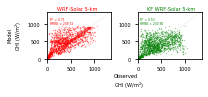

In [26]:
def scat(res, da_mean):   
    fig = plt.figure()
    gs = fig.add_gridspec(4, 15)
    x_new = np.linspace(0.01, 1360, 1000)
    
    ax00 = fig.add_subplot(gs[0:1, 0:3])
    plt_da = da_mean.iloc[59*nb_historical_days:,:] #
    ax00.scatter(x=plt_da['ghi_obs'],y=plt_da['ghi_mod'],c='red',s=0.1,alpha=0.5)
    plt.plot(x_new,x_new,c='gray',linewidth=0.1)
    ax00.text( 50, 1000,'RMSE = %0.2f'%fitting(plt_da)[7], fontsize=3, color='red')
    ax00.text( 50, 1100,'R* = %0.2f'%fitting(plt_da)[0], fontsize=3, color='red')
    ax00.text( 200, 1390,'WRF-Solar '+ str(res) + '-km', fontsize=5, color='red')
    ax00.tick_params(axis='both', which='major', labelsize=5)
    ax00.set_ylim(0,1360)
    ax00.set_xlim(0,1360)
    ax00.set_ylabel('Model\nGHI (W/m$^2$)',  fontsize=5)
    
    
    ax00 = fig.add_subplot(gs[0:1, 4:7])
    ax00.scatter(x=plt_da['ghi_obs'],y=plt_da['GHI_pred_improved'],c='green',s=0.1,alpha=0.5)
    plt.plot(x_new,x_new,c='gray',linewidth=0.1)
    ax00.tick_params(axis='both', which='major', labelsize=5)
    ax00.text( 50, 1100,'R* = %0.2f'%fitting_pred(plt_da)[0], fontsize=3, color='green')
    ax00.text( 50, 1000,'RMSE = %0.2f'%fitting_pred(plt_da)[7], fontsize=3, color='green')
    ax00.text( 200, 1390,'KF WRF-Solar '+ str(res) + '-km', fontsize=5, color='green')
    ax00.set_ylim(0,1360)
    ax00.set_xlim(0,1360)
    ax00.text( -500, -800,'Observed\nGHI (W/m$^2$)', fontsize=5, color='k')
    
    images_dir = 'img'
    plt.savefig(f"{images_dir}/kf_Manila_scatplot_" + str((res)) + "km.png", dpi=500, frameon=False, facecolor='white', bbox_inches="tight")

scat(5, df_temp)


Length ob:1271
Length obs:1271
Kendall correlation coefficient: 0.508
Samples are correlated (reject H0) p=0.000
Pearsons correlation: 0.675
Pearsons p_value: 0.000
RMS: 219.226
MAE: 164.168
###########################################
Length ob:1271
Length obs:1271
Kendall correlation coefficient: 0.508
Samples are correlated (reject H0) p=0.000
Pearsons correlation: 0.675
Pearsons p_value: 0.000
RMS: 219.226
MAE: 164.168
###########################################
Length pred:1271
Length pred:1271
Kendall correlation coefficient: 0.390
Samples are correlated (reject H0) p=0.000
Pearsons correlation: 0.509
RMS: 232.253
MAE: 169.032
###########################################
Length pred:1271
Length pred:1271
Kendall correlation coefficient: 0.390
Samples are correlated (reject H0) p=0.000
Pearsons correlation: 0.509
RMS: 232.253
MAE: 169.032
###########################################


/var/folders/m6/4qg_57053p93nhjn29vdbv940000gp/T/ipykernel_6664/2790719144.py:34: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(f"{images_dir}/cloudy_kf_Manila_scatplot_" + str((res)) + "km.png", dpi=500, frameon=False, facecolor='white', bbox_inches="tight")


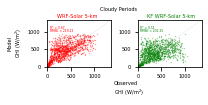

In [31]:
def scat_cloudy(res, da_mean):

    fig = plt.figure()
    gs = fig.add_gridspec(4, 15)
    x_new = np.linspace(0.01, 1360, 1000)
    
    ax00 = fig.add_subplot(gs[0:1, 0:3])
    plt_da = da_mean.iloc[59*nb_historical_days:,:]
    plt_da = plt_da[plt_da['flag_clear'] == 'N']
    ax00.scatter(x=plt_da['ghi_obs'],y=plt_da['ghi_mod'],c='red',s=0.1,alpha=0.5)
    plt.plot(x_new,x_new,c='gray',linewidth=0.1)
    ax00.text( 50, 1000,'RMSE = %0.2f'%fitting(plt_da)[7], fontsize=3, color='red')
    ax00.text( 50, 1100,'R* = %0.2f'%fitting(plt_da)[0], fontsize=3, color='red')
    ax00.text( 200, 1390,'WRF-Solar '+ str(res) + '-km', fontsize=5, color='red')
    ax00.tick_params(axis='both', which='major', labelsize=5)
    ax00.set_ylim(0,1360)
    ax00.set_xlim(0,1360)
    ax00.set_ylabel('Model\nGHI (W/m$^2$)',  fontsize=5)
    
    
    ax00 = fig.add_subplot(gs[0:1, 4:7])
    ax00.scatter(x=plt_da['ghi_obs'],y=plt_da['GHI_pred_improved'],c='green',s=0.1,alpha=0.5)
    plt.plot(x_new,x_new,c='gray',linewidth=0.1)
    ax00.tick_params(axis='both', which='major', labelsize=5)
    ax00.text( 50, 1100,'R* = %0.2f'%fitting_pred(plt_da)[0], fontsize=3, color='green')
    ax00.text( 50, 1000,'RMSE = %0.2f'%fitting_pred(plt_da)[7], fontsize=3, color='green')
    ax00.text( 200, 1390,'KF WRF-Solar '+ str(res) + '-km', fontsize=5, color='green')
    ax00.set_ylim(0,1360)
    ax00.set_xlim(0,1360)
    ax00.text( -500, -800,'Observed\nGHI (W/m$^2$)', fontsize=5, color='k')
    ax00.text( -800, 1600,'Cloudy Periods', fontsize=5, color='k')
    
    images_dir = 'img/2023_runs'
    plt.savefig(f"{images_dir}/cloudy_kf_Manila_scatplot_" + str((res)) + "km.png", dpi=500, frameon=False, facecolor='white', bbox_inches="tight")

scat_cloudy(5, df_temp)


Length ob:123
Length obs:123
Kendall correlation coefficient: 0.915
Samples are correlated (reject H0) p=0.000
Pearsons correlation: 0.986
Pearsons p_value: 0.000
RMS: 43.197
MAE: 35.556
###########################################
Length ob:123
Length obs:123
Kendall correlation coefficient: 0.915
Samples are correlated (reject H0) p=0.000
Pearsons correlation: 0.986
Pearsons p_value: 0.000
RMS: 43.197
MAE: 35.556
###########################################
Length pred:123
Length pred:123
Kendall correlation coefficient: 0.588
Samples are correlated (reject H0) p=0.000
Pearsons correlation: 0.804
RMS: 216.439
MAE: 177.938
###########################################
Length pred:123
Length pred:123
Kendall correlation coefficient: 0.588
Samples are correlated (reject H0) p=0.000
Pearsons correlation: 0.804
RMS: 216.439
MAE: 177.938
###########################################


/var/folders/m6/4qg_57053p93nhjn29vdbv940000gp/T/ipykernel_6664/4233002088.py:34: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(f"{images_dir}/clear_kf_Manila_scatplot_" + str((res)) + "km.png", dpi=500, frameon=False, facecolor='white', bbox_inches="tight")


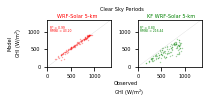

In [30]:
def scat_clear(res, da_mean):

    fig = plt.figure()
    gs = fig.add_gridspec(4, 15)
    x_new = np.linspace(0.01, 1360, 1000)
    
    ax00 = fig.add_subplot(gs[0:1, 0:3])
    plt_da = da_mean.iloc[59*nb_historical_days:,:]
    plt_da = plt_da[plt_da['flag_clear'] == 'Y']
    ax00.scatter(x=plt_da['ghi_obs'],y=plt_da['ghi_mod'],c='red',s=0.1,alpha=0.5)
    plt.plot(x_new,x_new,c='gray',linewidth=0.1)
    ax00.text( 50, 1000,'RMSE = %0.2f'%fitting(plt_da)[7], fontsize=3, color='red')
    ax00.text( 50, 1100,'R* = %0.2f'%fitting(plt_da)[0], fontsize=3, color='red')
    ax00.text( 200, 1390,'WRF-Solar '+ str(res) + '-km', fontsize=5, color='red')
    ax00.tick_params(axis='both', which='major', labelsize=5)
    ax00.set_ylim(0,1360)
    ax00.set_xlim(0,1360)
    ax00.set_ylabel('Model\nGHI (W/m$^2$)',  fontsize=5)
    
    
    ax00 = fig.add_subplot(gs[0:1, 4:7])
    ax00.scatter(x=plt_da['ghi_obs'],y=plt_da['GHI_pred_improved'],c='green',s=0.1,alpha=0.5)
    plt.plot(x_new,x_new,c='gray',linewidth=0.1)
    ax00.tick_params(axis='both', which='major', labelsize=5)
    ax00.text( 50, 1100,'R* = %0.2f'%fitting_pred(plt_da)[0], fontsize=3, color='green')
    ax00.text( 50, 1000,'RMSE = %0.2f'%fitting_pred(plt_da)[7], fontsize=3, color='green')
    ax00.text( 200, 1390,'KF WRF-Solar '+ str(res) + '-km', fontsize=5, color='green')
    ax00.set_ylim(0,1360)
    ax00.set_xlim(0,1360)
    ax00.text( -500, -800,'Observed\nGHI (W/m$^2$)', fontsize=5, color='k')
    ax00.text( -800, 1600,'Clear Sky Periods', fontsize=5, color='k')
    
    images_dir = 'img/2023_runs'
    plt.savefig(f"{images_dir}/clear_kf_Manila_scatplot_" + str((res)) + "km.png", dpi=500, frameon=False, facecolor='white', bbox_inches="tight")

scat_clear(5, df_temp)


/var/folders/m6/4qg_57053p93nhjn29vdbv940000gp/T/ipykernel_6664/3746056551.py:47: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(f'{images_dir}/timeseries.png', dpi=500, frameon=False, facecolor='white', bbox_inches="tight")


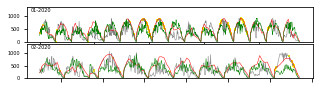

In [59]:
'''
subplot where each row is one month
y-axis 0-1400
x-axis 600 to 1900 LST
plot limits for clear-sky cases as per test 1
a) normalized total shortwave FN 
b) measured total shortwave and diffuse shortwave
'''
fig = plt.figure()
gs = fig.add_gridspec(18, 7)
    
  
for m in np.arange(1, 3, 1):
        
    sb = df_temp[(df_temp['MM']==m) ]
    
    #sb['SPN1_Total_Solar'] = sb['SPN1_Total_Solar'].replace(np.nan,0)
    #sb['t1_cc_val'] = sb['t1_cc_val'].replace(0,np.nan)
    if (m==1):
        i = 0

    if (m==2):
        i = 3


    ax00 = fig.add_subplot(gs[i:i+3, 0:6])
    plt.text(0.05, 0.9, f'{m:02}-2020', fontsize=5,horizontalalignment='center', verticalalignment='center', transform=ax00.transAxes)

    #ax00.plot(sb.index,sb['GHI_in'],c='gray',linewidth=0.5)
    ax00.scatter(sb.index,sb['ghi_cc_val'],marker='+',c='yellow',s=5)

    ax00.plot(sb.index,sb['ghi_obs'],c='gray',linewidth=0.5)

    ax00.plot(sb.index,sb['ghi_mod'],c='red',linewidth=0.5)
    ax00.plot(sb.index,sb['GHI_pred_improved'],c='green',linewidth=0.5)
    
    ax00.tick_params(axis='both', which='major', labelsize=5)
    ax00.set_ylim(0,1360)
    ax00.xaxis.set_major_formatter(md.DateFormatter('%d'))
    ax00.set_xticklabels([])
    #ax00.set_xlim([datetime.date(2020, int(m), int(day))])
    
#ax00.set_ylabel('Total\nShortwave (W/m$^2$)',fontsize= 5)
#ax00.set_xlabel('Month-Day',fontsize= 5)

images_dir = 'img'
plt.savefig(f'{images_dir}/timeseries.png', dpi=500, frameon=False, facecolor='white', bbox_inches="tight")



In [ ]:
'''
subplot where each row is one month
y-axis 0-1400
x-axis 600 to 1900 LST
plot limits for clear-sky cases as per test 1
a) normalized total shortwave FN 
b) measured total shortwave and diffuse shortwave
'''
fig = plt.figure()
gs = fig.add_gridspec(18, 7)
    
  
for m in np.arange(1, 3, 1):
        
    sb = df_temp[(df_temp['MM']==m) ]
    
    #sb['SPN1_Total_Solar'] = sb['SPN1_Total_Solar'].replace(np.nan,0)
    #sb['t1_cc_val'] = sb['t1_cc_val'].replace(0,np.nan)
    if (m==1):
        i = 0

    if (m==2):
        i = 3


    ax00 = fig.add_subplot(gs[i:i+3, 0:6])
    plt.text(0.05, 0.9, f'{m:02}-2020', fontsize=5,horizontalalignment='center', verticalalignment='center', transform=ax00.transAxes)

    ax00.plot(sb.index,sb['GHI_in'],c='gray',linewidth=0.5)


    ax00.plot(sb.index,sb['ghi_obs'],c='DarkBlue',linewidth=1.)

    ax00.plot(sb.index,sb['ghi_mod'],c='red',linewidth=0.5)
    ax00.plot(sb.index,sb['GHI_pred_improved'],c='green',linewidth=0.5)
    ax00.scatter(sb.index,sb['ghi_cc_val'],c='k',s=0.2)
    ax00.tick_params(axis='both', which='major', labelsize=5)
    ax00.set_ylim(0,1360)
    ax00.xaxis.set_major_formatter(md.DateFormatter('%d'))
    ax00.set_xticklabels([])
    #ax00.set_xlim([datetime.date(2020, int(m), int(day))])
    
#ax00.set_ylabel('Total\nShortwave (W/m$^2$)',fontsize= 5)
#ax00.set_xlabel('Month-Day',fontsize= 5)

images_dir = 'img'
plt.savefig(f'{images_dir}/timeseries.png', dpi=500, frameon=False, facecolor='white', bbox_inches="tight")

